### Fine-tuning mt5 for cleaning italian ocr text

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm 
import evaluate
import numpy as np
from datasets import load_from_disk
import seaborn as sns
import random

2025-08-22 21:19:03.625611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load datasets

In [2]:
train = load_from_disk("../datasets/t5-datasets/train")

# We reserve a 10% of the training set for evaluation
train = train.train_test_split(test_size=0.1)

In [3]:
train_dataset = train['train']
eval_dataset = train['test']

#### Load mt5-small and its tokenizer

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained("../../mt5-small")
tokenizer = AutoTokenizer.from_pretrained("../../mt5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/gjergj/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#### Preparing the data for fine-tuning

Before proceeding, let's first check the length of the encoded samples.

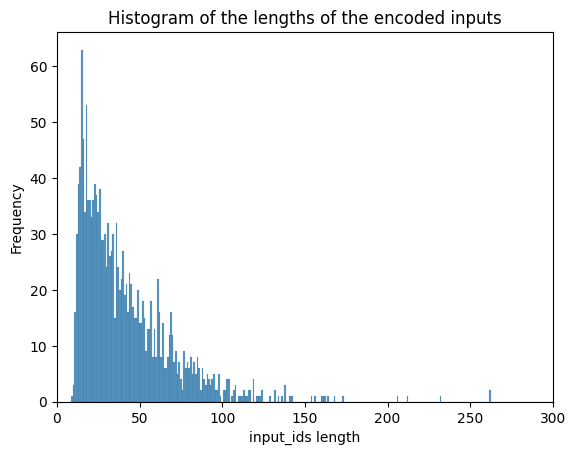

In [5]:
encoded_inputs_length = [] # store the length of the encoded samples

for sample in train_dataset:
    input_ids = tokenizer.encode(sample['ocr'], return_tensors='pt')
    encoded_inputs_length.append(len(input_ids[0]))

encoded_inputs_length.sort(reverse=True)

sns.histplot(encoded_inputs_length, bins=10, discrete=True)

plt.xlim(0, 300)
plt.xlabel('input_ids length')
plt.ylabel('Frequency')
plt.title('Histogram of the lengths of the encoded inputs')

plt.show()

The predefined input length of mt5 is 20 tokens. But as we can see from the histogram above, the tokenized samples are longer than just 20 tokens. Therefore, in order to not lose too much data, instead of just truncating the samples, we create chunks of 20 tokens. As an example, the two strings:

ocr:  
   \ 

iiiastri 
Si  avviticchiò  colle  braccia,  stretto  stretto,  al  collo  
della  sua  piamata  cavalcatura.

clean:  
Si avviticchiò colle braccia, stretto stretto, al collo della sua piumata cavalcatura.

become:
```
['▁', '\\', '▁iii', 'a', 'stri', '▁Si', '▁avvi', 'tic', 'chi', 'ò', '▁colle', '▁', 'braccia', ',', '▁stret', 'to', '▁stret', 'to', ',', '</s>']
['▁Si', '▁avvi', 'tic', 'chi', 'ò', '▁colle', '▁', 'braccia', ',', '▁stret', 'to', '▁stret', 'to', ',', '▁al', '▁collo', '▁', 'della', '▁sua', '</s>']

['▁al', '▁collo', '▁', 'della', '▁sua', '▁pi', 'amata', '▁caval', 'c', 'atura', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['▁piu', 'mata', '▁caval', 'c', 'atura', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
```

NOTE: To avoid having examples that are too short (in some extreme cases composed by just the EOS token), we truncate the sentence when 
the residual length of the sample is less than 5 tokens.


In [ ]:
def pad_function(ocr_chunk, clean_chunk):
    ''' 
    Function that takes as input the ocr_chunk and clean_chunk, 
    adds the EOS token (if needed) and pads the samples (if needed) 
    to have the correct length
    '''
    if len(ocr_chunk) < 20:
        # if the length of the tensor is less than 20, we pad it
        while len(ocr_chunk) < 20:
            ocr_chunk = torch.cat((ocr_chunk, torch.tensor([0]))) 
    else:
        # keep only the first 20 tokens
        ocr_chunk = ocr_chunk[:20]
        if ocr_chunk[-1].item() != 1:       # if needed, add </s> (EOS) token
            ocr_chunk[-1] = 1

    if len(clean_chunk) < 20:
        while len(clean_chunk) < 20:
            clean_chunk = torch.cat((clean_chunk, torch.tensor([0]))) 
    else:
        # keep only the first 20 tokens
        clean_chunk = clean_chunk[:20]
        if clean_chunk[-1].item() != 1:
            clean_chunk[-1] = 1

    return (ocr_chunk, clean_chunk)
        

' \nocr: 20\n tensor([   333,    298, 100835,    712,    277,  28116,    261,    259,    265,\n           259,   4166,    603,    318,    264,    259,  16138,    393,    400,\n           260,      1])\nclean: 17\n tensor([   298, 100835,    712,    293,  28116,    261,    259,    265,    259,\n          4166,    421,  26257,    393,    400,    260,      1,      1])\nocr: 20\n tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])\nclean: 20\n tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])\n\n'

In [7]:
def create_chunks(ocr_tokens, clean_tokens):
    ''' 
    Function that creates chunks of 20 tokens
    '''
    pairs = []
    max_len = max(len(ocr_tokens), len(clean_tokens))
    for i in range(0, max_len, 19): # 19 beacuse we need to reserve one token for the
                                    # end of sentence (</s>) token
        
        if i == 0:
            if min(len(ocr_tokens), len(clean_tokens)) < 25:         
                # when one of the two samples is shorter than 20 tokens, 
                # we make sure that the EOS token is present in both of them 
                # and pad (if needed) the samples to have the correct length
                pair = pad_function(ocr_tokens, clean_tokens)
                pairs.append(pair)

                return pairs

            else:
                # otherwise, we take the next 19 tokens and add the EOS token
                ocr_chunk = ocr_tokens[:19]
                clean_chunk = clean_tokens[:19]

                # Add EOS token
                ocr_chunk = torch.cat((ocr_chunk, torch.tensor([1])))
                clean_chunk = torch.cat((clean_chunk, torch.tensor([1])))

        else:
            
            if min(len(ocr_tokens[i:]), len(clean_tokens[i:])) < 25:
                ocr_chunk = ocr_tokens[i:]
                clean_chunk = clean_tokens[i:]

                pair = pad_function(ocr_chunk, clean_chunk)
                pairs.append(pair)

                return pairs
            
            else:
                ocr_chunk = ocr_tokens[i:i+19]
                clean_chunk = clean_tokens[i:i+19]

                # Add EOS token
                ocr_chunk = torch.cat((ocr_chunk, torch.tensor([1])))
                clean_chunk = torch.cat((clean_chunk, torch.tensor([1])))


        pairs.append((ocr_chunk, clean_chunk))
        
    return pairs
    

In [22]:
print(train_dataset[12]['ocr'])
print(train_dataset[12]['clean'])

 \ 

iiiastri 
Si  avviticchiò  colle  braccia,  stretto  stretto,  al  collo 
della  sua  piamata  cavalcatura.
Si avviticchiò colle braccia, stretto stretto, al collo della sua piumata cavalcatura.


In [25]:
ocr_tokens = tokenizer.encode(train_dataset[12]['ocr'], return_tensors='pt')[0]
clean_tokens = tokenizer.encode(train_dataset[12]['clean'], return_tensors='pt')[0]
pairs = create_chunks(ocr_tokens, clean_tokens)

In [26]:
for pair in pairs:
    print(f'ocr: {len(pair[0])}\n {pair[0]}')
    print(f'clean: {len(pair[1])}\n {pair[1]}')

ocr: 20
 tensor([   259,    540,  90965,    262,  19629,   1124,  81102,   6862,   2535,
          1133,  42944,    259, 144821,    261,  52346,    476,  52346,    476,
           261,      1])
clean: 20
 tensor([  1124,  81102,   6862,   2535,   1133,  42944,    259, 144821,    261,
         52346,    476,  52346,    476,    261,    440,  88249,    259,   1391,
          2379,      1])
ocr: 20
 tensor([   440,  88249,    259,   1391,   2379,   1952,  50085, 101253,    297,
         17235,    260,      1,      0,      0,      0,      0,      0,      0,
             0,      0])
clean: 20
 tensor([ 99614,   6666, 101253,    297,  17235,    260,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0])


In [27]:
for pair in pairs:
    ocr_tokens = tokenizer.convert_ids_to_tokens(pair[0])
    clean_tokens = tokenizer.convert_ids_to_tokens(pair[1])
    print(ocr_tokens)
    print(clean_tokens)

['▁', '\\', '▁iii', 'a', 'stri', '▁Si', '▁avvi', 'tic', 'chi', 'ò', '▁colle', '▁', 'braccia', ',', '▁stret', 'to', '▁stret', 'to', ',', '</s>']
['▁Si', '▁avvi', 'tic', 'chi', 'ò', '▁colle', '▁', 'braccia', ',', '▁stret', 'to', '▁stret', 'to', ',', '▁al', '▁collo', '▁', 'della', '▁sua', '</s>']
['▁al', '▁collo', '▁', 'della', '▁sua', '▁pi', 'amata', '▁caval', 'c', 'atura', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['▁piu', 'mata', '▁caval', 'c', 'atura', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [12]:
def encode_sample(sample, tokenizer):
    ''' 
    Function that tokenizes each sample, and passes them to 'create_chunks' function, 
    that creates chunks of 20 tokens

    - sample: ['ocr', 'clean']
    '''
    ocr = sample['ocr']
    clean = sample['clean']

    if ocr is None or clean is None:
        return None 
    
    input_token_ids = tokenizer.encode(ocr, return_tensors='pt')[0]
    target_token_ids = tokenizer.encode(clean, return_tensors='pt')[0]

    chunks = create_chunks(input_token_ids, target_token_ids)

    return chunks

In [13]:
def tokenize_dataset(dataset, tokenizer):
    tokenized_dataset = {}
    tokenized_dataset['ocr'] = []
    tokenized_dataset['clean'] = []

    for sample in dataset:
        chunks = encode_sample(sample, tokenizer)
        for pair in chunks:
            if pair[0] == None or pair[1] == None:
                continue

            tokenized_dataset['ocr'].append(pair[0])
            tokenized_dataset['clean'].append(pair[1])

    return tokenized_dataset


In [14]:
tokenized_train_data = tokenize_dataset(train_dataset, tokenizer)
tokenized_val_data = tokenize_dataset(eval_dataset, tokenizer)

In [15]:
# Sanity check, verify that the produced chuncks have all size 20
dataset_size = len(tokenized_train_data['ocr'])
for i in range(dataset_size):
    if tokenized_train_data['ocr'][i].shape != torch.Size([20]) or tokenized_train_data['clean'][i].shape != torch.Size([20]):
        print(i)
        print(tokenized_train_data['ocr'][i])
        print(tokenized_train_data['clean'][i])
        print('\n\n')
print("All fine")

All fine


Let's see what a sample looks like.

In [16]:
print(tokenized_train_data['ocr'][0])
print(tokenized_train_data['clean'][0])

tensor([  661,   415, 12270,  1135,  5916, 20665, 65626,   335, 12880,   421,
        46669,   261,   259,   265, 36072,   262,   264,   259, 65626,     1])
tensor([  661,   415, 12270,  1135,  5916, 20665, 65626,   335, 12880,   421,
        46669,   261,   259,   265, 36072,  9694,   268,   259,  7364,     1])


In [17]:
# Let's now take a general sample and retrieve the original text
ocr = tokenized_train_data['ocr'][1522]
clean = tokenized_train_data['clean'][1522]

In [18]:
ocr_text = tokenizer.decode(ocr, skip_special_tokens=True)
clean_text = tokenizer.decode(clean, skip_special_tokens=True)
print(ocr_text)
print(clean_text)

Pinoccliio, come potete fignrarvelo, si détte a
Pinocchio, come potete figurarvelo, si dètte a piangere,


**DATA GENERATOR**
Now we build a data generator that creates the batches for training at each epoch.

In [20]:
random.seed(42)

In [ ]:
''' 
function to create a generator object to generate batches of data
'''
def data_generator(dataset, batch_size, shuffle=False):
    ocr_samples = dataset['ocr']
    clean_samples = dataset['clean']

    # During training we shuffle the dataset at each epoch
    #if shuffle:
    #    random.shuffle(ocr_samples)    # YOU CAN'T SHUFFLE LIKE THIS
    #    random.shuffle(clean_samples)
        
    for i in range(0, len(ocr_samples), batch_size):
        
        inputs = ocr_samples[i: i+batch_size]
        targets = clean_samples[i: i+batch_size]
        
        batch_input_ids = torch.stack(inputs)
        batch_target_ids = torch.stack(targets)

        yield batch_input_ids, batch_target_ids


In [22]:
train_data_gen = data_generator(tokenized_train_data, batch_size=8)

In [23]:
print(len(tokenized_train_data['clean']))

3700


In [24]:
print(len(tokenized_val_data['clean']))

397


In [47]:
data_batch = next(train_data_gen)
#print('data_batch:',data_batch[0])
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

Input shape: torch.Size([8, 20])
Output shape: torch.Size([8, 20])


In [48]:
ocr_samples = data_batch[0]
clean_samples = data_batch[1]

for i in range(len(ocr_samples)):
    ocr = ocr_samples[i]
    clean = clean_samples[i]
    ocr_text = tokenizer.decode(ocr, skip_special_tokens=True)
    clean_text = tokenizer.decode(clean, skip_special_tokens=True)
    print(f'ocr:{ocr_text}, clean:{clean_text}')

ocr:corsa, entrò nell'acqua anche lui., clean:viaggio per ritornarsene a casa sua.
ocr:padella d'olio, che mandava un odorino di moccolaia, da, clean:Hai voluto fare a modo tuo, ma te ne pentirai!
ocr:Allora diventò pensieroso, e, dimenticando le regole del Galat, clean:— e sarei volentieri tornato alla spiaggia: ma come fare?
ocr:Dormi dunque tranquillamen- te, e stai sicuro che prima di partire, clean:Uno di quei monelli agguantò quel volume, e presa di mira la testa
ocr:eri di giunco : e coi quattrini che ne ricavava, prov, clean:ò un branco dei soliti compagni, che andandogli incontro, gli
ocr:essere un granchio di mare., clean:— Chi è?— disse una vocina di dentro.
ocr:— Anche tuo padre! — ìsOj no, no, il mio povero, clean:, via, e via, come andrebbe una palla di fucile.
ocr:XXIV. Pinocchio arriva all'isola delle « Api industriose » e ri, clean:E per questo io lo volli ammaestrare nelballo nonchè nei relativi


### Dataset Preparation (with DataLoader from pytorch)

In [19]:
class CustomDataset(data.Dataset):

    def __init__(self, dataset):
        super().__init__()

        ''' 
        - dataset: Python dictionary of the form:
                   {'ocr': [list of ocr samples], 'clean': [list of the corresponding clean samples]}
        '''
        
        self.data = []
        self.num_samples = len(dataset['ocr'])
        self.ocr_samples = dataset['ocr']
        self.clean_samples = dataset['clean']

        # training data will be a list of dictionaries
        # each dictionary contains two keys: 'ocr' and 'clean' 

        for i in range(self.num_samples):
            ocr_sample = self.ocr_samples[i]
            clean_sample = self.clean_samples[i]

            sample = {'ocr': ocr_sample, 'clean': clean_sample}
            self.data.append(sample)

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, index):
        return self.data[index]
    

In [20]:
training_samples = CustomDataset(dataset=tokenized_train_data)
val_samples = CustomDataset(dataset=tokenized_val_data)  

### Training 

In [21]:
# training hyperparameters
n_epochs = 2
train_batch_size = 8
eval_batch_size = 4
print_freq = 25
lr = 5e-4
len_dataset = len(training_samples)
n_batches = int(np.ceil(len_dataset / train_batch_size))
total_steps = n_epochs * n_batches 
n_warmup_steps = int(total_steps * 0.01)

In [22]:
print(f'Total Steps: {total_steps}')
print(f'Warmup Steps: {n_warmup_steps}')

Total Steps: 918
Warmup Steps: 9


In [23]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
# We define a scheduler that will take care of adapting the learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

#### The Trainer class

In [24]:
class Trainer():

    def __init__(self, model, optimizer, scheduler, num_epochs):
        self.model = model 
        self.optimizer = optimizer
        self.scheduler = scheduler 
        self.num_epochs = num_epochs

    def train(self, train_dataset, val_dataset):

        train_loss = []
        val_loss = []
        for epoch_idx in range(n_epochs):   

            for batch_idx, sample in tqdm(enumerate(train_dataset), total=n_batches):

                input_batch = sample['ocr']
                label_batch = sample['clean']

                # zero the gradients
                optimizer.zero_grad()

                # forward pass
                model_out = model.forward(
                    input_ids = input_batch, 
                    labels = label_batch    # not strictly necessarily, but if we do it,
                                            # it computes the loss for us
                )

                loss = model_out.loss
                train_loss.append(loss.item())

                # compute the gradients
                loss.backward()

                # update the weights
                optimizer.step()

                # The scheduler adaptes the leraning rate
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    #average loss for the last 'print_freq' batches
                    avg_loss = np.mean(train_loss[-print_freq:])
                    eval_loss = self.eval_model(val_dataset)
                    val_loss.append(eval_loss)
                    print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
                        epoch_idx+1, batch_idx+1, avg_loss, eval_loss, scheduler.get_last_lr()[0]))
                    

        return {
            "train_loss": train_loss, 
            "val_loss": val_loss
        }
    

    def eval_model(self, validation_dataset):
        eval_losses = []

        with torch.no_grad():
            for sample in validation_dataset:
                input_batch = sample['ocr']
                label_batch = sample['clean']

                # forward pass
                model_out = model.forward(input_ids=input_batch, 
                                        labels=label_batch)     # As before we pass also the labels, so it 
                                                                # computes for us also the loss
            
                eval_losses.append(model_out.loss.item())

        
        return np.mean(eval_losses)

The last thing to do, before training, is to load the data using the `DataLoader` module.

In [25]:
training_dataset = DataLoader(training_samples, batch_size=train_batch_size, shuffle=True)
validation_dataset = DataLoader(val_samples, batch_size=eval_batch_size)

In [26]:
trainer = Trainer(model=model,
                  optimizer=optimizer, 
                  num_epochs=n_epochs, 
                  scheduler=scheduler)

In [27]:
history = trainer.train(training_dataset, validation_dataset)

  0%|          | 0/459 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 1 | Step: 25 | Avg. train loss: 15.381 | Avg. val loss: 6.979 | lr: 0.0004911991199119912
Epoch: 1 | Step: 50 | Avg. train loss: 5.981 | Avg. val loss: 4.766 | lr: 0.0004774477447744774
Epoch: 1 | Step: 75 | Avg. train loss: 4.103 | Avg. val loss: 3.485 | lr: 0.0004636963696369637
Epoch: 1 | Step: 100 | Avg. train loss: 3.201 | Avg. val loss: 2.812 | lr: 0.00044994499449945
Epoch: 1 | Step: 125 | Avg. train loss: 2.705 | Avg. val loss: 2.251 | lr: 0.00043619361936193617
Epoch: 1 | Step: 150 | Avg. train loss: 2.075 | Avg. val loss: 1.826 | lr: 0.00042244224422442246
Epoch: 1 | Step: 175 | Avg. train loss: 1.777 | Avg. val loss: 1.462 | lr: 0.00040869086908690874
Epoch: 1 | Step: 200 | Avg. train loss: 1.489 | Avg. val loss: 1.295 | lr: 0.0003949394939493949
Epoch: 1 | Step: 225 | Avg. train loss: 1.213 | Avg. val loss: 1.222 | lr: 0.0003811881188118812
Epoch: 1 | Step: 250 | Avg. train loss: 1.253 | Avg. val loss: 1.167 | lr: 0.0003674367436743675
Epoch: 1 | Step: 275 | Avg. tra

  0%|          | 0/459 [00:00<?, ?it/s]

Epoch: 2 | Step: 25 | Avg. train loss: 0.890 | Avg. val loss: 0.943 | lr: 0.0002387238723872387
Epoch: 2 | Step: 50 | Avg. train loss: 0.873 | Avg. val loss: 0.929 | lr: 0.000224972497249725
Epoch: 2 | Step: 75 | Avg. train loss: 0.806 | Avg. val loss: 0.924 | lr: 0.00021122112211221123
Epoch: 2 | Step: 100 | Avg. train loss: 0.780 | Avg. val loss: 0.916 | lr: 0.00019746974697469746
Epoch: 2 | Step: 125 | Avg. train loss: 0.800 | Avg. val loss: 0.912 | lr: 0.00018371837183718374
Epoch: 2 | Step: 150 | Avg. train loss: 0.743 | Avg. val loss: 0.907 | lr: 0.00016996699669966997
Epoch: 2 | Step: 175 | Avg. train loss: 0.708 | Avg. val loss: 0.903 | lr: 0.0001562156215621562
Epoch: 2 | Step: 200 | Avg. train loss: 0.838 | Avg. val loss: 0.900 | lr: 0.0001424642464246425
Epoch: 2 | Step: 225 | Avg. train loss: 0.849 | Avg. val loss: 0.897 | lr: 0.00012871287128712872
Epoch: 2 | Step: 250 | Avg. train loss: 0.851 | Avg. val loss: 0.892 | lr: 0.00011496149614961496
Epoch: 2 | Step: 275 | Avg. 

In [ ]:
# Save the model and tokenizer
model.save_pretrained("../model/fine-tuned-models")
tokenizer.save_pretrained("../model/fine-tuned-models")

('../model/fine-tuned-models/tokenizer_config.json',
 '../model/fine-tuned-models/special_tokens_map.json',
 '../model/fine-tuned-models/spiece.model',
 '../model/fine-tuned-models/added_tokens.json',
 '../model/fine-tuned-models/tokenizer.json')

Let's see what a batch looks like

In [36]:
batch = next(iter(training_dataset))
print(batch)

{'ocr': tensor([[   259,  70432,    277,  42605,    734,    335,    277,  20103,  11341,
           1319,    261,    259,   2651,    421,   2852,    859,    264,    393,
         210436,      1],
        [   277,  15046,    261,   8353,   2519,    265,  83665,    834,    335,
            416,    264,    350, 130600,    260,      1,      0,      0,      0,
              0,      0],
        [   259, 140814,    261,    259,    265,    935,    707,  38323,   1133,
            267,  60322,   1133,    573,   3302,    262,   9682,    261,    259,
            265,      1],
        [   259,    309,  10259,    573,  11341,   1319,    261,    734,    935,
           3396,   5475,    421,   2852,    260,      1,      0,      0,      0,
              0,      0],
        [   262,  29866,    277,   8065,    259,    266,    268,    259,   2634,
          12880,  19224,    259,  48335,    268,    261, 117209,   1856,    259,
            265,      1],
        [   496,    335,    277,  20103,   9682,    

Let's now decode the previous samples

In [37]:
ocr_samples = batch['ocr']
clean_samples = batch['clean']

for i in range(len(ocr_samples)):
    ocr = ocr_samples[i]
    clean = clean_samples[i]
    ocr_text = tokenizer.decode(ocr, skip_special_tokens=True)
    clean_text = tokenizer.decode(clean, skip_special_tokens=True)
    print(f'ocr:{ocr_text}, clean:{clean_text}')

ocr:Quand'ecco che un'altra risata, anche più im- pertinente, clean:Quand’ecco che un’altra risata, anche più impertinente della
ocr:'oro, dalla quale pendeva un me- daglione., clean:, dalla quale pendeva un medaglione.
ocr:colazione, e non lo trovò: tornò una seconda volta, e, clean:, e nonlo trovò: tornò una seconda volta, e Lucignolo
ocr:! Fu una risata, che non finiva più., clean:Fu una risata, che non finiva più.
ocr:a quest' ora io ero belPe fritto, mangiato e, clean:quest’ora io ero bell’e fritto, mangiato e
ocr:ma un'altra volta non mi farò tanto pregare, clean:ma un’altra volta non mi farò tanto pregare!
ocr:— Sicurissimo. — Ma lo sai dicerto, clie le vacanze abbia, clean:— Sicurissimo.— Ma lo sai dicerto, che le vacanze abbiano principi
ocr:e monete d' oro., clean:monete d’oro.


In [32]:
for epoch_idx in range(n_epochs):
    data = data_generator(tokenized_train_data, batch_size, shuffle=True)   

    for batch_idx, (input_batch, label_batch) in tqdm(enumerate(data), total=n_batches):

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        model_out = model.forward(
            input_ids = input_batch, 
            labels = label_batch    # not strictly necessarily, but if we do it,
                                    # it computes the loss for us
        )

        loss = model_out.loss
        train_loss.append(loss.item())

        # compute the gradients
        loss.backward()

        # update the weights
        optimizer.step()

        # The scheduler adaptes the leraning rate
        scheduler.step()

        if (batch_idx + 1) % print_freq == 0:
            #average loss for the last 'print_freq' batches
            avg_loss = np.mean(train_loss[-print_freq:])
            eval_loss = eval_model(model, tokenized_val_data)
            eval_losses.append(eval_loss)
            print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
                epoch_idx+1, batch_idx+1, avg_loss, eval_loss, scheduler.get_last_lr()[0]))

torch.save(model.state_dict(), '../model/mt5_finetuned')



  0%|          | 0/463 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 1 | Step: 25 | Avg. train loss: 15.536 | Avg. val loss: 10.378 | lr: 0.0009825517993456924
Epoch: 1 | Step: 50 | Avg. train loss: 10.377 | Avg. val loss: 7.387 | lr: 0.000955288985823337
Epoch: 1 | Step: 75 | Avg. train loss: 6.812 | Avg. val loss: 6.092 | lr: 0.0009280261723009815
Epoch: 1 | Step: 100 | Avg. train loss: 5.944 | Avg. val loss: 5.455 | lr: 0.0009007633587786259
Epoch: 1 | Step: 125 | Avg. train loss: 5.430 | Avg. val loss: 5.038 | lr: 0.0008735005452562704
Epoch: 1 | Step: 150 | Avg. train loss: 5.074 | Avg. val loss: 4.780 | lr: 0.0008462377317339149
Epoch: 1 | Step: 175 | Avg. train loss: 5.026 | Avg. val loss: 4.552 | lr: 0.0008189749182115595
Epoch: 1 | Step: 200 | Avg. train loss: 4.689 | Avg. val loss: 4.318 | lr: 0.000791712104689204
Epoch: 1 | Step: 225 | Avg. train loss: 4.483 | Avg. val loss: 4.114 | lr: 0.0007644492911668485
Epoch: 1 | Step: 250 | Avg. train loss: 4.243 | Avg. val loss: 4.020 | lr: 0.000737186477644493
Epoch: 1 | Step: 275 | Avg. train

  0%|          | 0/463 [00:00<?, ?it/s]

Epoch: 2 | Step: 25 | Avg. train loss: 3.464 | Avg. val loss: 3.586 | lr: 0.0004776444929116685
Epoch: 2 | Step: 50 | Avg. train loss: 3.407 | Avg. val loss: 3.562 | lr: 0.00045038167938931295
Epoch: 2 | Step: 75 | Avg. train loss: 3.490 | Avg. val loss: 3.516 | lr: 0.00042311886586695745
Epoch: 2 | Step: 100 | Avg. train loss: 3.380 | Avg. val loss: 3.508 | lr: 0.000395856052344602
Epoch: 2 | Step: 125 | Avg. train loss: 3.385 | Avg. val loss: 3.505 | lr: 0.0003685932388222465
Epoch: 2 | Step: 150 | Avg. train loss: 3.536 | Avg. val loss: 3.472 | lr: 0.00034133042529989094
Epoch: 2 | Step: 175 | Avg. train loss: 3.337 | Avg. val loss: 3.467 | lr: 0.00031406761177753544
Epoch: 2 | Step: 200 | Avg. train loss: 3.318 | Avg. val loss: 3.454 | lr: 0.00028680479825518
Epoch: 2 | Step: 225 | Avg. train loss: 3.315 | Avg. val loss: 3.425 | lr: 0.00025954198473282443
Epoch: 2 | Step: 250 | Avg. train loss: 3.306 | Avg. val loss: 3.409 | lr: 0.00023227917121046893
Epoch: 2 | Step: 275 | Avg. tr

#### Plots

In [31]:
def plot(data, label):
    plt.plot(data, label=label)
    plt.legend()
    plt.show()

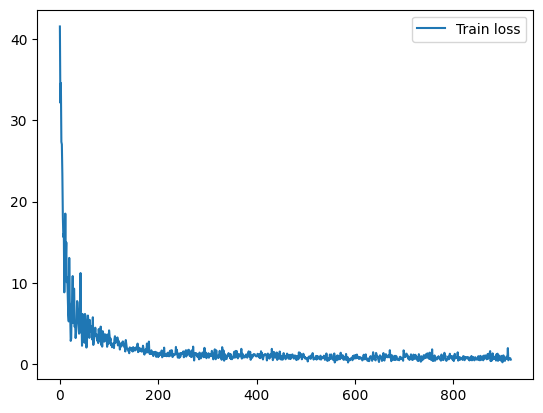

In [32]:
plot(history['train_loss'], label='Train loss')

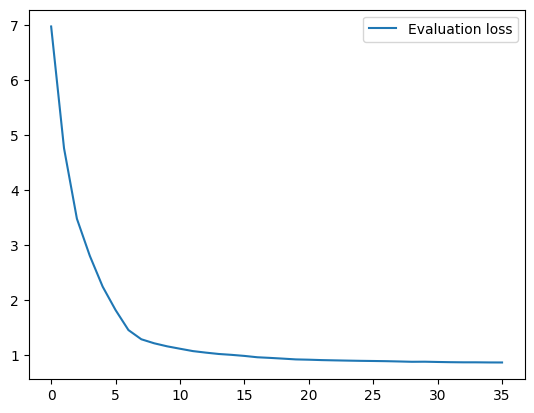

In [33]:
plot(history['val_loss'], label='Evaluation loss')

#### Testing and Inference

In [ ]:
# Load the model
mt5_finetuned = AutoModelForSeq2SeqLM.from_pretrained("../model/fine-tuned-models")
mt5_tokenizer = AutoTokenizer.from_pretrained("../model/fine-tuned-models")

In [34]:
# Load the test dataset
test = load_from_disk("../datasets/t5-datasets/test")

In [39]:
ocr_sample = test[0]['ocr']
clean_sample = test[0]['clean']

In [40]:
print(f'ocr_sample:\n{ocr_sample}\n')
print(f'clean_sample:\n{clean_sample}')

ocr_sample:
I. 
Como  andò  che  Maestro  Ciliegia,  Megnamc 
trovò  un  pezzo  di  legno  che  piangeva  e  rideva  come  un  bambino.

clean_sample:
I.Come andò che Maestro Ciliegia, falegname
trovò un pezzo di legno che piangeva e rideva come un bambino.


In [41]:
input_ids = tokenizer.encode(ocr_sample, return_tensors='pt')[0]
input_ids = input_ids.unsqueeze(0)

output_tokens = model.generate(input_ids, num_beams=1, num_return_sequences=1)
prediction = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
print(prediction)

I. Come andò che Maestro c’il mondo che piangeva e rideva come


In [38]:
for token_set in output_tokens:
    prediction = tokenizer.decode(token_set,skip_special_tokens=True)

    print(prediction)

— ragazzi, avete sbagliato.


#### Rouge scores

As before, we'll need to create chunks of data.

In [50]:
print(test)

Dataset({
    features: ['ocr', 'clean'],
    num_rows: 244
})


In [ ]:
def chunk_sample(sample):
    chunks = []
    sample_size = len(sample)
    for i in range(0, sample_size, 19):
        if 


In [51]:
def encode_test_sample(dataset):
    chunked_dataset = []
    for sample in dataset:
        ocr = sample['ocr']
        ocr_input_ids = tokenizer.encode(ocr, return_tensors='pt')[0]
        chunks = chunk_sample(ocr_input_ids)
        for t in chunks:
            chunked_dataset.append(t)
    
    return chunked_dataset


In [45]:
metric = evaluate.load("rouge")

In [46]:
def compute_rouge(dataset, model):
    '''
    - dataset: test dataset 
    '''

    model.eval()

    test_data = data_generator(dataset, tokenizer, batch_size=4)

    all_decoded_preds = []
    all_decoded_labels = []

    #test_losses = []
    for _, (input_batch, label_batch) in enumerate(test_data):
        preds = model.generate(input_batch, num_beams=1, num_return_sequences=1)
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(label_batch, skip_special_tokens=True)

        all_decoded_preds.extend(decoded_preds)
        all_decoded_labels.extend(decoded_labels)

    result = metric.compute(predictions=all_decoded_preds, references=all_decoded_labels)

    return result
    


In [47]:
rouge_scores = compute_rouge(test, model)

NameError: name 'data_generator' is not defined

In [86]:
print(rouge_scores)

{'rouge1': 0.7774912485382005, 'rouge2': 0.69925788533276, 'rougeL': 0.7726068291210269, 'rougeLsum': 0.7731892934093172}
